# Time-Series Prediction

## Introduction

predicting the future weather of a city using weather-data from several other cities.

Because we will be working with sequences of arbitrary length, we will use a Recurrent Neural Network (RNN).


## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

C:\Users\DELL PC\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This was developed using Python 3.6 (Anaconda) and package versions:

In [2]:
tf.__version__

'1.10.0'

In [3]:
tf.keras.__version__

'2.1.6-tf'

In [4]:
pd.__version__

'0.20.1'

## Load Data

In [9]:
# Second weather data that includes measured min, max and mean temperatures
weather = pd.read_csv("Summary of Weather.csv")

C:\Users\DELL PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
weather.head()

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# what we will use only
weather = weather.loc[:,["STA","Date","MeanTemp"] ]
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 3 columns):
STA         119040 non-null int64
Date        119040 non-null object
MeanTemp    119040 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


C:\Users\DELL PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


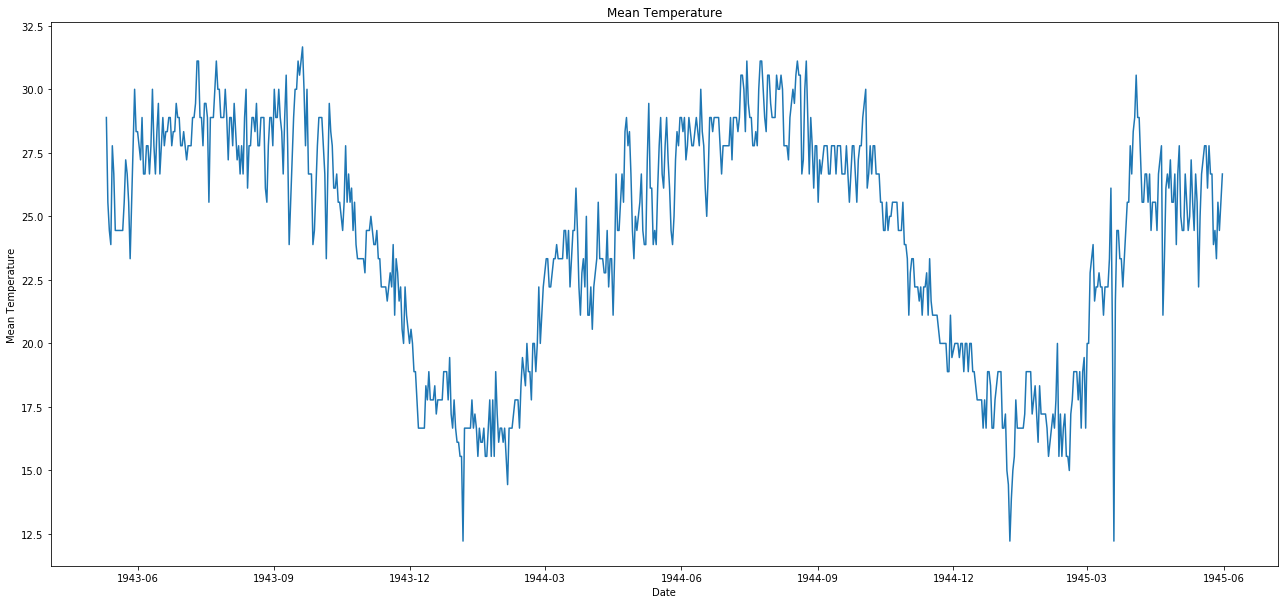

In [13]:
weather_bin = weather[weather.STA == 32907]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp)
plt.title("Mean Temperature")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [14]:
# lets create time series from weather 
timeSeries = weather_bin.loc[:, ["Date","MeanTemp"]]


In [15]:
timeSeries
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date",axis=1)
#ts

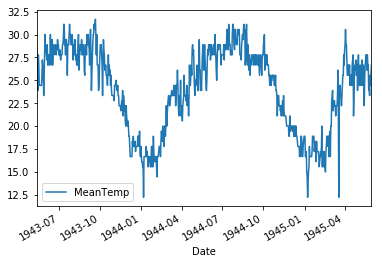

In [16]:
ts.plot()

In [17]:
ts.tail()

,MeanTemp
Date,
1945-05-27,23.333333
1945-05-28,25.555556
1945-05-29,24.444444
1945-05-30,25.555556
1945-05-31,26.666667


## We will add a column name DayOfYear and Month to our custom csv and import it as Mean temperature clearly is seasonal and depends on day on the year

In [88]:
myTimeSeries = timeSeries
myTimeSeries['Month'] = timeSeries.index.month
myTimeSeries['DayOfYear'] = timeSeries.index.dayofyear

In [89]:
myTimeSeries.head()

,Date,MeanTemp,Month,DayOfYear
Date,,,,
1943-05-11,1943-05-11,28.888889,5,131
1943-05-12,1943-05-12,25.555556,5,132
1943-05-13,1943-05-13,24.444444,5,133
1943-05-14,1943-05-14,23.888889,5,134
1943-05-15,1943-05-15,27.777778,5,135


In [90]:
myTimeSeries.shape

(751, 4)

In [91]:
myTimeSeries.to_csv('monthadnDOY.csv')

In [92]:
myTimeSeries = pd.read_csv('monthadnDOY.csv')

In [93]:
#training on first 600
X_train = myTimeSeries.loc[0:600,["Month","DayOfYear"]].values
Y_train = myTimeSeries.loc[0:600,["MeanTemp"]].values

#testing on 150
X_test = myTimeSeries.loc[601:,["Month","DayOfYear"]].values
Y_test = myTimeSeries.loc[601:,["MeanTemp"]].values

In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
Y_train_scaled = scaler.fit_transform(Y_train)
X_test_scaled = scaler.fit_transform(X_test)
Y_test_scaled = scaler.fit_transform(Y_test)

C:\Users\DELL PC\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


# Reshaping input to be 3D [samples, timesteps, features]
We need to reshape the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [95]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [96]:
print(X_train_scaled.shape, Y_train_scaled.shape, X_test_scaled.shape, Y_test_scaled.shape)

(601, 1, 2) (601, 1) (150, 1, 2) (150, 1)


# Training LSTM Model

In [126]:
import keras
from keras.models import Sequential
from keras import layers

In [127]:
model = Sequential()
model.add(layers.GRU(512,  input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(70)) # put return_sequences=True, in first LSTM to have more LSTM layers
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 512)               791040    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [130]:
history = model.fit(X_train_scaled, 
                    Y_train_scaled, 
                    epochs=1, 
                    batch_size=10,
                    validation_data=(X_test_scaled, Y_test_scaled), 
                    verbose=2, 
                    shuffle=False)

Train on 601 samples, validate on 150 samples
Epoch 1/1
 - 3s - loss: 0.1671 - val_loss: 0.0195


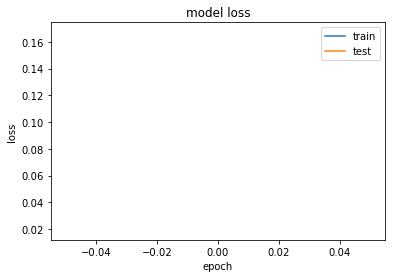

In [131]:
# summarizing history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Weather Predictions on test set

In [132]:
# make a prediction
predictions = model.predict(X_test_scaled)

In [133]:
predictions.shape

(150, 1)

In [134]:
X_test_scaled.shape

(150, 1, 2)

In [135]:
# invert scaling for forecast
X_test_scaled_inv = X_test_scaled.reshape((X_test_scaled.shape[0], X_train_scaled.shape[2]))
inv_predictions = np.concatenate((predictions, X_test_scaled_inv[:, -1:]), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

In [136]:
inv_predictions.shape

(150,)

In [137]:
# invert scaling for actual
Y_test_scaled_inv = Y_test_scaled.reshape((len(Y_test_scaled), 1))
inv_actual = np.concatenate((Y_test_scaled_inv, X_test_scaled_inv[:, -1:]), axis=1)
inv_actual = scaler.inverse_transform(inv_actual)
inv_actual = inv_actual[:,0]


In [138]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(inv_predictions, inv_actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.557


In [139]:
inv_predictions.shape

(150,)

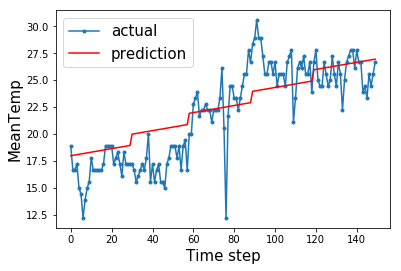

In [140]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(150)]
plt.plot(aa, inv_actual[:150], marker='.', label="actual")
plt.plot(aa, inv_predictions[:150], 'r', label="prediction")
plt.ylabel('MeanTemp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()